## Group 3 - Project 2
# Online Shopper Purchase Prediction

In [18]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import model as Group3Models

In [19]:
#Read in CSV
online_shopping_df = pd.read_csv('online_shoppers_intention.csv')

online_shopping_df.info()

online_shopping_df["Revenue"].value_counts()

# online_shopping_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Visualize PCA

In [20]:
pca_model = PCA(n_components=2)

<Axes: xlabel='OperatingSystems', ylabel='Count'>

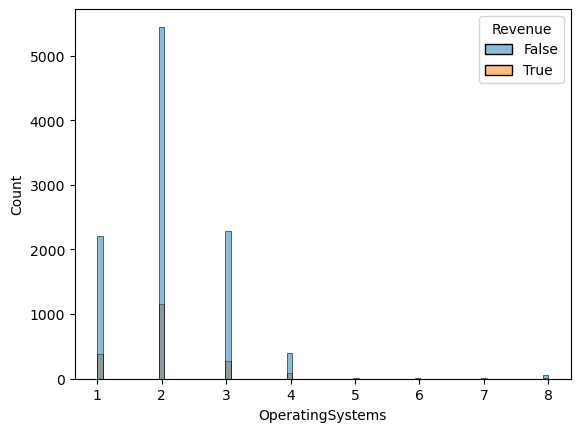

In [21]:
#EDA
sns.histplot(data=online_shopping_df, x='OperatingSystems', hue='Revenue')

<Axes: xlabel='ExitRates', ylabel='Count'>

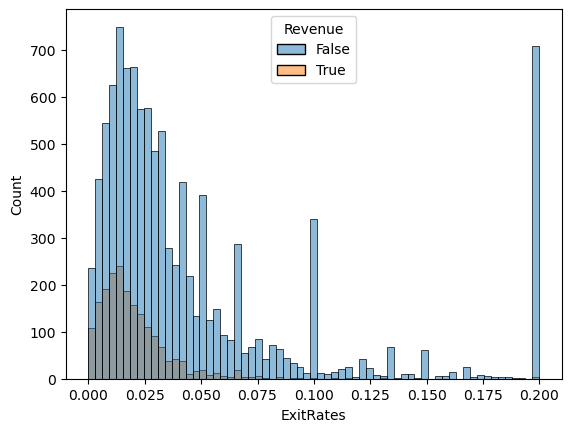

In [22]:
sns.histplot(data=online_shopping_df, x='ExitRates', hue='Revenue')

In [ ]:
#Drop the target column, setup X and y datasets for train test split
X = online_shopping_df.drop('Revenue', axis=1)
y = online_shopping_df['Revenue']

X.head()

# Set seed for reproducibility
SEED = 42

#Train Test Split
X_test, X_train, y_test, y_train = train_test_split(X, y, random_state=SEED)
X_train.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

## Add Encodings to Feature Columns

In [ ]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
X_train['VisitorType'] = ordinal_encoder.fit_transform(X_train[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_train['Month'] = ordinal_encoder.fit_transform(X_train[['Month']])
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
2509,0,0.000000,0,0.0,16,534.916667,0.000000,0.021250,0.0,0.0,4.0,2,2,7,3,2.0,False
9038,0,0.000000,0,0.0,3,58.500000,0.000000,0.066667,0.0,0.0,11.0,2,4,1,2,2.0,False
10329,9,303.866667,0,0.0,72,3752.666970,0.007042,0.007280,0.0,0.0,10.0,1,1,1,3,2.0,False
9420,0,0.000000,0,0.0,37,2323.166667,0.010811,0.018198,0.0,0.0,10.0,1,2,4,2,2.0,False
4091,0,0.000000,0,0.0,2,10.000000,0.000000,0.100000,0.0,0.0,4.0,1,1,1,3,2.0,False


<Axes: >

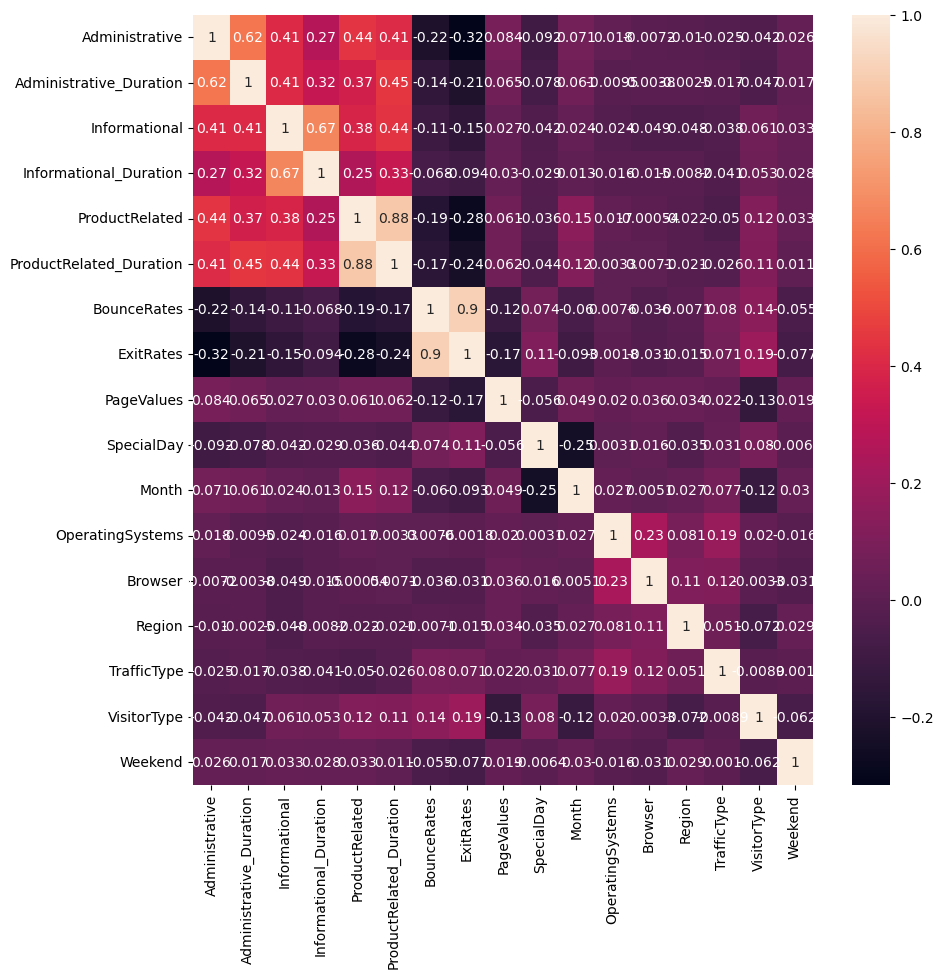

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=X_train.corr(), annot=True)

## Create a Model and predict

In [ ]:
#Create a Random Forest Classifier
# model = Group3Models.don_model()
# model.fit(X_train, y_train)
# model.score(X_test, y_test)
# y_pred = model.predict(X_test)

In [ ]:
# print(classification_report(y_test, y_pred))
Group3Models.evaluate_models(X_test, y_test)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.